We learned in last file that regular expressions provide powerful ways to describe patterns in text that can help us clean and extract data.

We're going to continue working with the dataset from technology site [Hacker News](https://news.ycombinator.com/).

Let's start by reading in the dataset 

`library(stringr)`

`library(readr)`

`hn  <-  read_csv("hacker_news.csv")`

`titles  <-  hn$title`

In the story titles, for example, we have two different capitalizations for the `Python` language: `Python` and `python`. In the last file, we learned three techniques for handling cases like these.

1. The first is to use a **set** to match either `P` or `p`. `"[Pp]ython"`
2. The second techniques is **alternative** patterns. `"Python|python"`.
3. The last technique is to use `(?i)` the **ignorecase flag** to make our pattern case insensitive. `"(?i)python"`

The ignorecase flag is particularly useful when we have many different capitalizations for a word or phrase. In our dataset, the SQL language has three different capitalizations: `SQL`, `sql`, and `Sql`.

**Task**

* Use a single ignorecase flag to write a case-insensitive version of `sql`.

**Answer**

`sql_pattern  <-  "(?i)SQL"
sql_counts  <-  sum(str_detect(titles, sql_pattern))`

We counted the number of mentions of `"SQL"` in the `titles` of stories. As we learned in the last file, we have two ways to extract those mentions:

1. If we want to extract the complete matching, we use [`str_extract()` function](https://stringr.tidyverse.org/reference/str_extract.html)
2. If we want only a targetted part of the matching pattern, we need to do two things:
    - Use the [`str_match()` function](https://stringr.tidyverse.org/reference/str_match.html)
    - Use a regex capture group

We define a capture group by wrapping the part of our pattern we want to capture in parentheses. If we just wrap the whole pattern in a pair of parentheses, `str_match()` will capture the whole pattern:

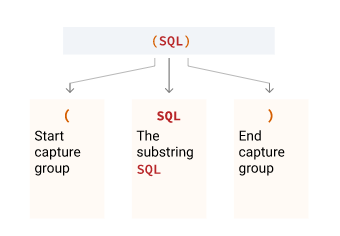

Let's look at how we can use a capture group to create a frequency table of the different capitalizations of SQL in our dataset.

`pattern  <-  "(?i)(SQL)
sql_capitalizations  <-  str_match(titles, pattern)[,2]`

For each element of the vector — `titles` — if there is a matching, `"SQL"`, `"sql"`, or `"Sql"` are outputted (as it is in the title) otherwise `NA`.

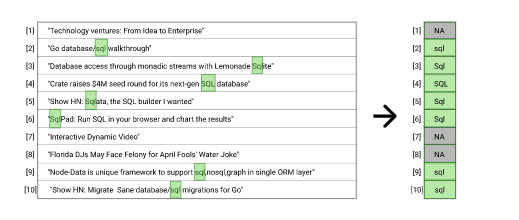

Lastly, we use the [`table()` function](https://stat.ethz.ch/R-manual/R-devel/library/base/html/table.html) to create a frequency table of those capitalizations:

`sql_capitalizations_freq  <-  table(sql_capitalizations)
print(sql_capitalizations_freq)`

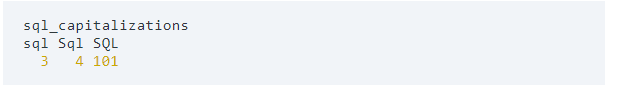

We can extend this analysis by looking at titles that have letters immediately before the "SQL", which is a convention often used to denote different variations or flavors of SQL. To do so, we can build a new pattern from the previous one, `"(?i)(SQL)"`, by taking into account:

* Letters immediately before the "SQL" using the word character class (`\w`) with the "one or more" quantifier (`+`).
* Double the backslash of `\w`, in the R code, to avoid wrong string interpretation.

`pattern  <-  "(?i)(\\w+SQL)"
sql_flavors  <-  str_match(titles, pattern)[,2]
sql_flavors_freq  <-  table(sql_flavors)
print(sql_flavors_freq)`

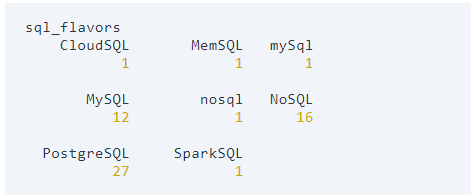

Notice how there is some duplication due to varied capitalization in this frequency table:

* `NoSQL` and `nosql`
* `MySQL` and `mysql`

One way to get rid of this issue is to use [`str_to_lower()` or `str_to_upper()` functions](https://stringr.tidyverse.org/reference/case.html) to transform SQL flavors into lower or upper case before applying the `table()` function.

`sql_flavors_freq  <-  table(str_to_lower(sql_flavors))
print(sql_flavors_freq)`

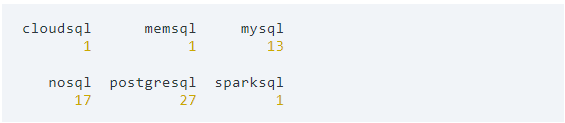

**Task**

In order to compute how many `python 2`, `python 3`, etc are mentioned in `titles`:

* Extract the mentions of different python flavors and its version
* Clean those duplicates by making them all lowercase

**Answer**

`pattern  <-  "(?i)(python [\\d])"
python_flavors  <-  str_match(titles, pattern)[,2]
python_titles_freq  <-  table(str_to_lower(python_flavors))`

We can use capture groups to extract only the version of Python that is mentioned most often in our dataset by wrapping parentheses around the part of our regular expression which captures the version number.

**Task**

* Use a capture group to capture the version number after the word "Python," and then build a frequency table of the different versions.

**Answer**

`pattern <- "[Pp]ython ([\\d\\.]+)"
python_versions <- str_match(python_titles, pattern)[,2]
python_versions_freq <- table(python_versions)`

Let's start with a simple regex that matches the letter "c" with `word boundary anchors` on either side:

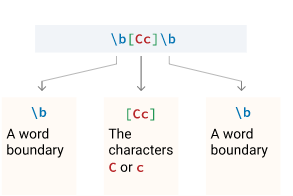

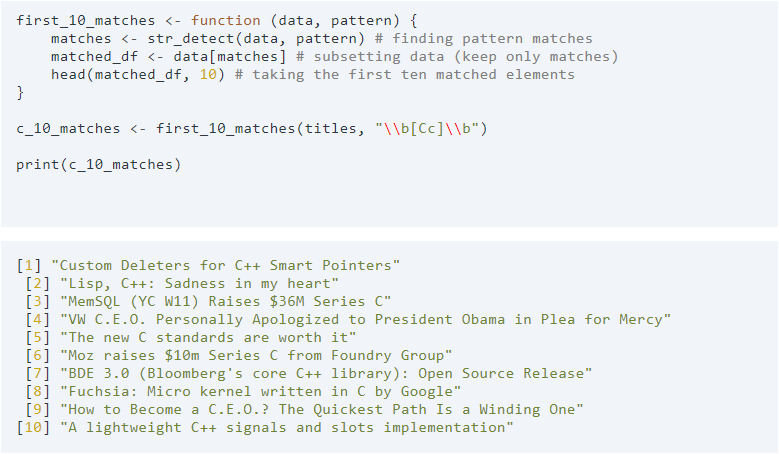

Immediately, our results are reasonably relevant. However, we can quickly identify a few match types we want to prevent:

* Mentions of C++, a distinct language from C.
* Cases where the letter C is followed by a period, like in the substring `C.E.O`.

**Task**

* Let's use a negative set to prevent matches for the `+` character and the `.`

**Answer**

`first_10_matches <- function (data, pattern) {
    matches <- str_detect(data, pattern) # finding pattern matches
    matched_df <- data[matches] # subsetting data (keep only matches)
    head(matched_df, 10) # taking the first ten matched elements`
    
`pattern  <-  "\\b[Cc]\\b[^.+]"
first_ten  <-  first_10_matches(titles, pattern)`

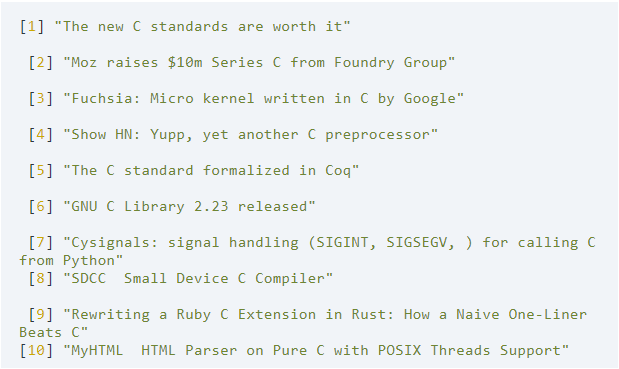

It looks like we're getting close. We have one irrelevant result in our first 10 matches, which is about `"Series C`," a term used to represent a particular type of startup fundraising.

Additionally, we've run into the same issue as we did — by using a negative set, we may have eliminated any instances where the last character of the title is "C" (the second last line of output matches in spite of the fact that it ends with "C," because it also has "C" earlier in the string).

Neither of these can be avoided using negative sets, which are used to allow multiple matches for a single character. Instead we'll need a new tool: **lookarounds**.

Lookarounds let us define a character or sequence of characters that either must or must not come before or after our regex match. There are four types of lookarounds:

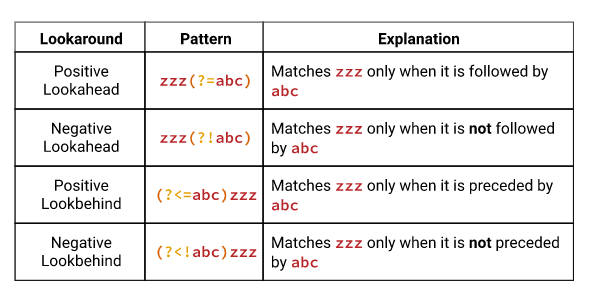

Let's create some test data that we'll use to illustrate how lookarounds work:

`test_cases  <-  c(
                   'Red_Green_Blue',
                   'Yellow_Green_Red',
                   'Red_Green_Red',
                   'Yellow_Green_Blue',
                   'Green'
                 )`

We'll also create a function that will tell us whether our pattern matches or not. This function will output the matching pattern if it there is a match otherwise "NO MATCH".

`run_test_cases <- function(data, pattern){
    data_matches <- str_match(data, pattern) # extracting pattern mentions
    data_matches[is.na(data_matches)] <- "NO MATCH" # assigning "NO MATCH" to mismatch patterns
    data_matches
}`

Let's start by using a **positive lookahead** to include instances where the match is followed by the substring `_Blue`.

`run_test_cases(test_cases, "Green(?=_Blue)")`

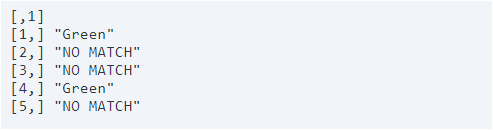

Let's look at a **negative lookahead** to include instances where the match is not followed by the substring `_Red`:

`run_test_cases(test_cases, "Green(?!_Red)")`

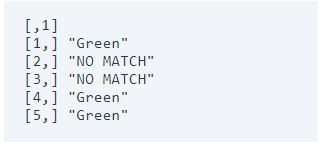

Next, we'll use a **positive lookbehind** to include instances where the match is preceded by the substring `Red_`:

`run_test_cases(test_cases, "(?<=Red_)Green")`

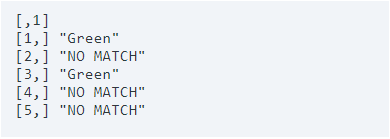

And finally, using a **negative lookbehind** to include instances where the match isn't preceded by the substring `Yellow_`:

`run_test_cases(test_cases, "(?<!Yellow_)Green")`

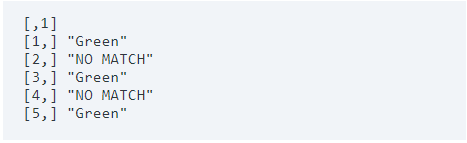

The contents of a lookaround can include any other regular expression component. For instance, here is an example where we match only cases that are followed by exactly five characters:

`run_test_cases(test_cases, "Green(?=.{5})")`

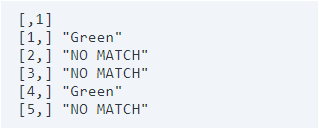

The second and third test cases are followed by four characters, not five, and the last test case isn't followed by anything.

Sometimes programming languages won't implement support for all lookarounds (notably, lookbehinds are not in the official JavaScript specification). As an example, to get full support in the [RegExr](https://regexr.com/) tool, we'll need to set it to use the `PCRE regex` engine.

**Task**

* Use lookarounds to exclude the matches we don't want. We want to:

    - Keep excluding matches that are followed by `.` or `+`, but still match cases where "C" falls at the end of the string.
    - Exclude matches that have the word `'Series'` immediately preceding them.
    
**Answer**

`pattern  <-  "(?<!Series\\s)\\b[Cc]\\b(?![\\+\\.])"
c_mentions  <-  sum(str_detect(titles, pattern))`

Let's say we wanted to identify strings that had words with double letters, like the "ee" in "feed." Because we don't know ahead of time what letters might be repeated, we need a way to specify a capture group and then to repeat it. We can do this with **backreferences**.

Whenever we have one or more capture groups, we can refer to them using integers left to right as shown in this regex that matches the string `HelloGoodbye`:

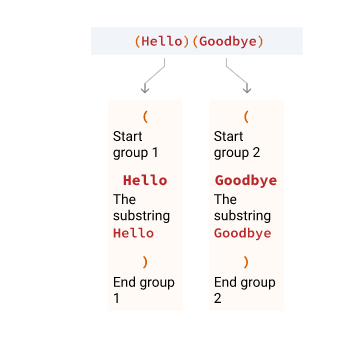

Within a regular expression, we can use a backslash followed by that integer to refer to the group:

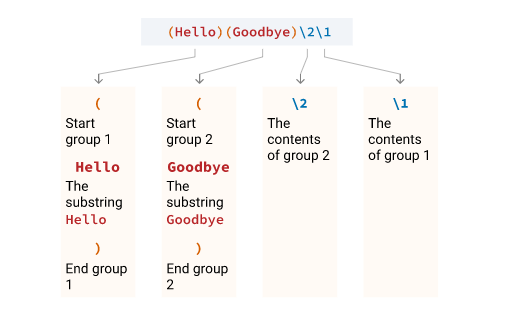

The regular expression above will match the text `HelloGoodbyeGoodbyeHello`. Let's look at how we could write a regex to capture instances of the same two word characters in a row:

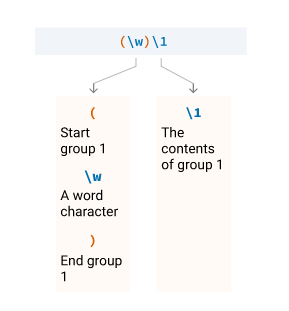

Let's see this in action using R:

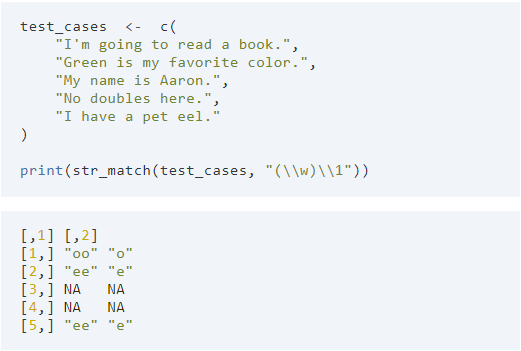

Notice that there was no match for the word `Aaron`, despite it containing a double "a." This is because the uppercase and lowercase "a" are two different characters, so the backreference does not match.

**Task**

* Use above technique to identify story titles that have repeated words.

**Answer**

`pattern  <-  "\\b(\\w+)\\s\\1\\b"
repeated_words  <-  titles[str_detect(titles, pattern)]`

We learned how to: - Use capture group regular expressions and the `str_match()` function to extract mentions of pattern - Clean different mentions of pattern flavors with `str_to_lower()` function - Count the different mentions.

All those operations were performed over `vector`. Now we will clean our dataset.

**Task**

* We're going to extract the mentions of different SQL flavors into a new column and clean those duplicates by making them all lowercase. 
* We'll then analyze the results to look at the average number of comments for each flavor.

**Answer**

`library(dplyr)
library(stringr)
pattern  <-  "(?i)(\\w+SQL)"
hn_sql <-  hn %>% 
    filter(str_detect(title, pattern)) %>%
    mutate(flavor = str_match(title, pattern)[,2]) %>%
    mutate(flavor = str_to_lower(flavor))`

`hn_sql_flavor_avg <- hn_sql %>%
    select(flavor, num_comments) %>%
    group_by(flavor) %>%
    summarise(avg = mean(num_comments))`

Now we are interested in how to replace matching patterns by another string.

To do so, we use the [`str_replace()` or `str_replace_all()` functions](https://stringr.tidyverse.org/reference/str_replace.html) from stringr package. The basic syntax for `str_replace()` and `str_replace_all()` is:

`str_replace(string, pattern, replacement)
str_replace_all(string, pattern, replacement)`

The replacement parameter is the text that we would like to substitute for the match. The difference between `str_replace()` and `str_replace_all()` is that the first replaces only the first match while the second replaces all matches.

* Where we replace the first capital letters in a string with dash:

`string  <-  "aBcDEfGHIj"`

`print(str_replace(string, "[A-Z]", "-"))`

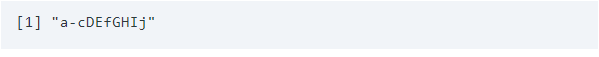

* Where we replace all capital letters in a string with dashes:

`string  <-  "aBcDEfGHIj"`

`print(str_replace_all(string, "[A-Z]", "-"))`

**Task**

`email_variations  <-  c('email', 'Email', 'e Mail',
                        'e mail', 'E-mail', 'e-mail',
                        'eMail', 'E-Mail', 'EMAIL')`

1. Use a regular expression to replace each of the matches in `email_variations` with "email"

2. Replace all variations of email in `titles` with "email"

**Answer**

`pattern  <-  "(?i)e[\\-\\s]?mail"
email_uniform  <-  str_replace(email_variations, pattern, "email")
titles_clean  <-  str_replace(titles, pattern, "email")`

Now we'll extract components of URLs from our dataset. The task we will be performing first is extracting the different components of the URLs in order to analyze them. We'll start by extracting just the domains.

The domain of each URL excludes the protocol (e.g. `https://`) and the page path (e.g. `/Technology-Ventures-Enterprise-Thomas-Byers/dp/0073523429`).

Once we have extracted the domains, we will build a frequency table to determine the most popular domains. There are over 7,000 unique domains in our dataset, so to make the frequency table easier to analyze, we'll look at only the top 20 domains.

**Task**

* Extract the domains and build a frequency table to determine the 20 most popular domains. 
* Because all of the URLs either end with the domain or continue with page path which starts with `/` (a character not found in any domains), we don't need to cater for this part of the URL in our regular expression.

**Answer**

`pattern  <-  "(?i)https?://([\\w\\.]+)"
domains  <- str_match(hn$url, pattern)[,2]
top_domains  <-  head(table(domains),20)`

Having extracted just the domains from the URLs, we'll extract each of the three component parts of the URLs:

1. Protocol
2. Domain
3. Page path

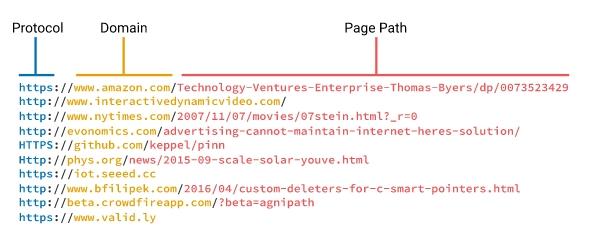

In order to do this, we'll create a regular expression with multiple capture groups. Multiple capture groups in regular expressions are defined the same way as single capture groups — using pairs of parentheses.

Let's look at how this works using the first few values from the `created_at` column in our dataset:

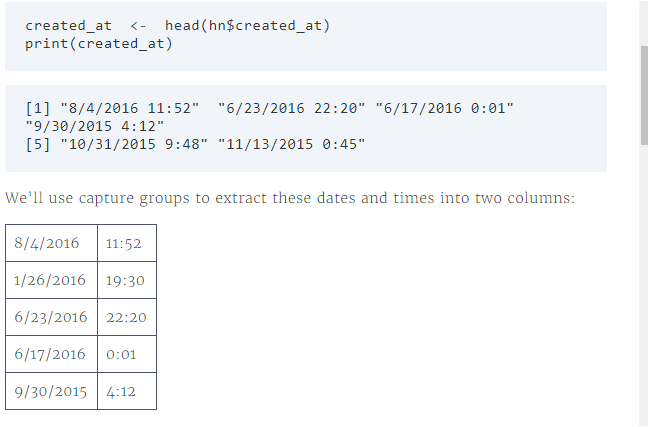

In order to do this, we can write the following regular expression:

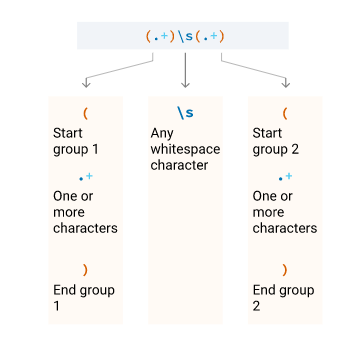

Notice how we put a space character between the capture groups, which matches the space character in the original strings.

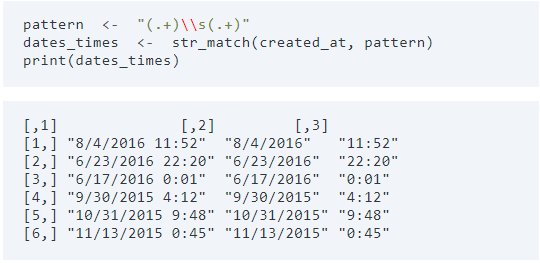

**Task**

* Write a regular expression that will extract the URL components into individual columns of a dataframe.
    * Create in this dataframe a column `protocol` to store the protocols.
    - Create in this dataframe a column `domain` to store the domains.
    - Create in this dataframe a column `page_path` to store the page path.
    
**Answer**

`pattern  <-  "(.+)://([\\w\\.]+)/?(.*)"`

`hn_urls  <-  hn %>%
    mutate(protocol = str_match(url, pattern)[,2]) %>%
    mutate(domain = str_match(url, pattern)[,3]) %>%
    mutate(page_path = str_match(url, pattern)[,4])`

In this file, we learned advanced regular expression techniques to help us work with text data, including:

* Using multiple capture groups to extract URL data.
* How to use lookarounds to customize matches based on the surrounding text.
* How to substitute a regular expression match to clean inconsistent data.
* How to modifier function to change the standard behaviour of the matching.

These techniques allow us to clean and analyze text data in extremely powerful ways.